<a href="https://colab.research.google.com/github/amaluvincent/Applied-data-science-/blob/main/Keras_Assignment_Sep23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Data Science 2 - Keras Assignment - 2023A

In this assignment you will be building a script to classify images of animals. The assignment is broken up into sections and you need to complete each section successively. The sections are:

1. Data Processing
2. Model Definition
3. Model Training
4. Model Evaluation

In addition to this coding exercise, you will also need to write a 1-2 page report analysing and critically evaluating you models results.

In [1]:
# Enter your module imports here, some modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model

In [2]:
# CodeGrade Tag Init1
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing



In [5]:
# CodeGrade Tag DataProc

label_dict = {'cat' : 0,
              'dog' : 1,
              'wild' : 2}

# This function is provided to read in the image files from the folder on your
# Google Drive
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]
  label = tf.strings.to_number(label)

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

img_loc = "/content/drive/MyDrive/Animals/"

train_list_ds = tf.data.Dataset.list_files(img_loc + "train/*/*")
valid_list_ds = tf.data.Dataset.list_files(img_loc + "val/*/*")





**Create a function called "img_process" converts the images to float32 datatype and resizes them to 64x64 pixels.**

In [6]:
# CodeGrade Tag Ex1a
### Write a function called img_process, which takes in the image and label as
### inputs, converts the data type of the image to tf.float32, resizes the
### image to (64,64), and finally returns the image and labels.

def img_process(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, [64, 64])
    return image, label



**Using the tf.data API, load in the training and validation data. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [7]:
# CodeGrade Tag Ex1b
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 128. Use techniques like caching and
### prefetching to efficiently load the data.


train_ds = (train_list_ds
            .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(128)
            .prefetch(tf.data.AUTOTUNE))

valid_ds = (valid_list_ds
            .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
            .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(128)
            .cache()
            .prefetch(tf.data.AUTOTUNE))



# Model Definition

**Using the Keras Functional API, create a convolutional neural network with the architecture show in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a SoftMax activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        1216      
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 GlobalPool (GlobalAverageP  (None, 128)               0         
 ooling2D)                                                       
                                                                 
 FC1 (Dense)                 (None, 512)               66048     
                                                                 
 Output (Dense)              (None, 10)                5130      
                                                                 
=================================================================
Total params: 363146 (1.39 MB)
Trainable params: 363146 (1.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [8]:
# CodeGrade Tag Ex2a
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.


# Input layer
input_layer = Input(shape=(64, 64, 3), name='Input')

# Convolutional layers
conv0 = Conv2D(16, (3, 3), activation='relu', padding='same', name='Conv0', strides=(2, 2))(input_layer)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv1')(conv0)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2')(conv1)
pool1 = MaxPooling2D((2, 2), name='Pool1')(conv2)

conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv3')(pool1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv4')(conv3)
pool2 = MaxPooling2D((2, 2), name='Pool2')(conv4)

conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv5')(pool2)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv6')(conv5)

# Global Average Pooling layer
global_pool = GlobalAveragePooling2D(name='GlobalPool')(conv6)

# Dense layers
fc1 = Dense(512, activation='relu', name='FC1')(global_pool)

# Output layer with 3 units for 3 classes
output_layer = Dense(3, activation='softmax', name='Output')(fc1)

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


In [9]:
# CodeGrade Tag Ex2b
### Print the model summary and confirm is has the same architecture as the one
### provided.

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928 

**Compile the model using the Adam Optimizer with a learning rate of ```5e-5```, ```sparse categorical crossentropy``` loss function, and ```accuracy``` metric.**

In [10]:
# CodeGrade Tag Ex2c

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Model Training

**Create a Model Checkpoint Callback that saves the weights of the best performing epoch, based on the validation accuracy.**

In [11]:
# CodeGrade Tag Ex3a
### Create a ModelCheckpoint callback to store the bext weights from the model,
### based on the validation accuracy. Call this callback "checkpoint_callback"

checkpoint_filepath = '/content/checkpoint'

# Create ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1)




**Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [12]:
# CodeGrade Tag Ex3b
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

# Create LearningRateScheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


**Train the model for 100 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [13]:
# CodeGrade Tag Ex3c
### Train the model for 100 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

# Number of epochs
epochs = 100

# Train the model with callbacks
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=valid_ds,
                    callbacks=[checkpoint_callback, lr_callback])



Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 1.0801 - accuracy: 0.4052 
Epoch 1: val_accuracy improved from -inf to 0.46467, saving model to /content/checkpoint
115/115 [==============================] - 1570s 14s/step - loss: 1.0801 - accuracy: 0.4052 - val_loss: 1.0321 - val_accuracy: 0.4647 - lr: 5.0000e-05
Epoch 2/100
114/115 [============================>.] - ETA: 0s - loss: 0.9262 - accuracy: 0.5285
Epoch 2: val_accuracy improved from 0.46467 to 0.60000, saving model to /content/checkpoint
115/115 [==============================] - 4s 33ms/step - loss: 0.9258 - accuracy: 0.5289 - val_loss: 0.8390 - val_accuracy: 0.6000 - lr: 5.0000e-05
Epoch 3/100
113/115 [============================>.] - ETA: 0s - loss: 0.8244 - accuracy: 0.5826
Epoch 3: val_accuracy improved from 0.60000 to 0.61400, saving model to /content/checkpoint
115/115 [==============================] - 3s 27ms/step - loss: 0.8245 - accuracy: 0.5827 - val_loss: 0.7971 - val_accuracy: 0.6140 - l

# Model Evaluation

**Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the models performance.**

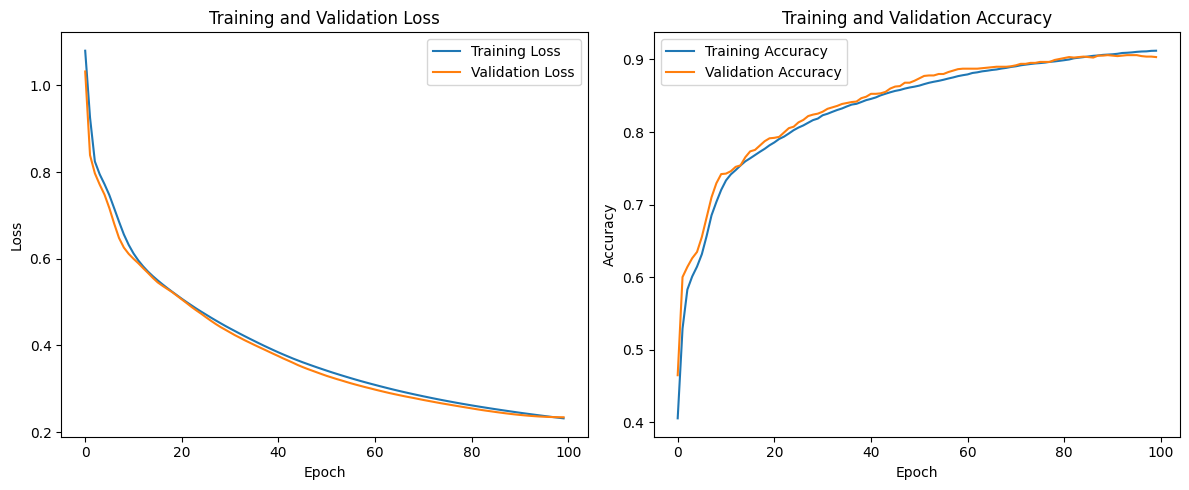

In [14]:
# CodeGrade Tag Ex4a

# Extract training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plotting the Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**Load the best weights from your model checkpoint, and create plots demonstrating the classification perfomnce for all three classes. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

4/4 [==============================] - 1s 6ms/step


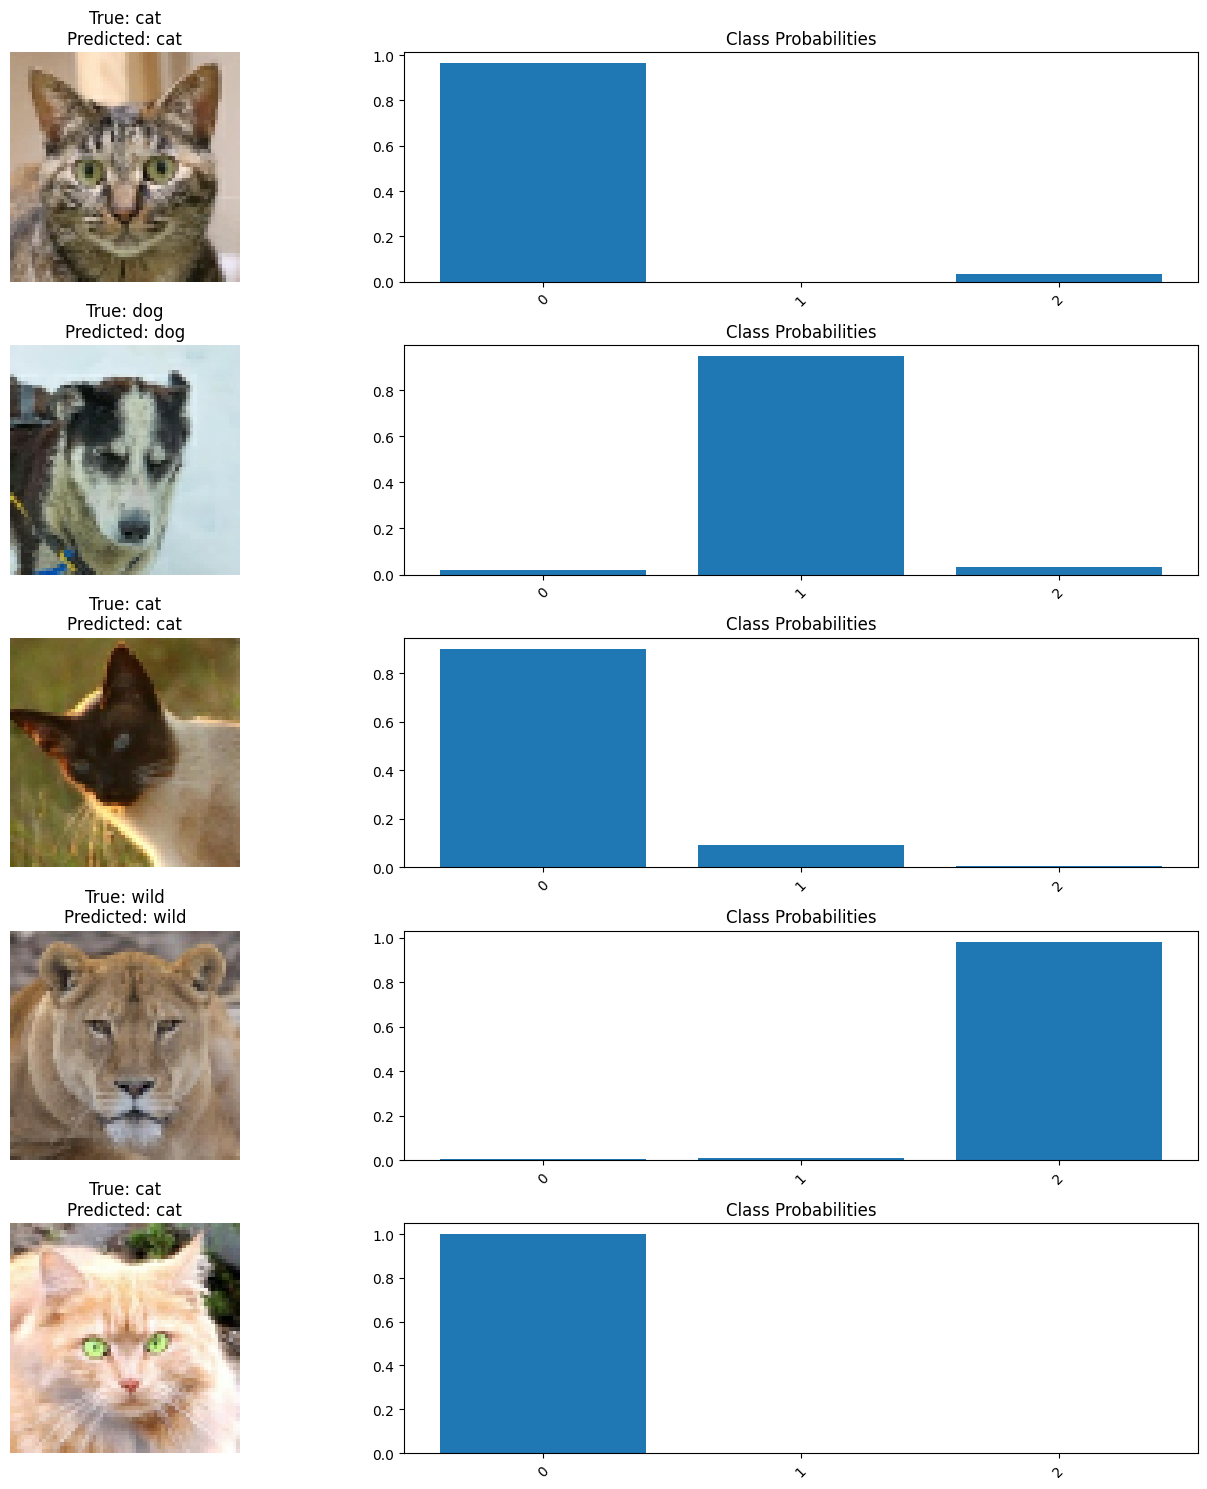

In [15]:
# CodeGrade Tag Ex4b

# Load the best weights
model.load_weights(checkpoint_filepath)

# Create a function to predict and plot images
def predict_and_plot(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 3*num_images))

    for images, labels in dataset.take(1):
        predictions = model.predict(images)

        for i in range(num_images):
            plt.subplot(num_images, 2, 2*i + 1)
            plt.imshow(images[i])
            plt.title(f"True: {class_names[labels[i].numpy()]}\nPredicted: {class_names[np.argmax(predictions[i])]}")
            plt.axis('off')

            plt.subplot(num_images, 2, 2*i + 2)
            plt.bar(range(len(class_names)), predictions[i])
            plt.xticks(range(len(class_names)), class_names, rotation=45)
            plt.title('Class Probabilities')

    plt.tight_layout()
    plt.show()

# Define class names based on your label_dict
class_names = {v: k for k, v in label_dict.items()}

# Predict and plot images from the validation dataset
predict_and_plot(valid_ds, class_names)
